<a href="https://colab.research.google.com/github/Andre-Williams22/fashion-recommendation-system/blob/master/Fashion_Recommender_Based_on_Seasonality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai
!pip install annoy
!pip install gdown
!pip install keras-resnet
!pip install keras

     |████████████████████████████████| 646 kB 5.3 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391621 sha256=4110b292f69c5d6e0cbde71fc3d23ede2308d72ac973eae86258e64ca524da4b
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=8372e47cbea3782803cf5f014067a08f84ad990f3642a6fec54c7f67439548c0
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
from google.colab import drive
%matplotlib inline

In [3]:
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is available!  Training on GPU ...
Tue Dec 14 11:12:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

## Get DeepFashion Data 

In [4]:
# # # get the meta data
# # url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pWnFiNlNGTVloLUk'
# # url = 'https://drive.google.com/drive/folders/0B7EVK8r0v71pWGplNFhjc01NbzQ?resourcekey=0-BU3lAk-Nc7HscJu-CyC1yA&usp=sharing'
# # url = 'https://drive.google.com/file/d/1JYqeD2gUtWcYWU31QQ1fTCnDX7CN2KpA/view?usp=sharing'
# url = 'https://drive.google.com/file/d/0B7EVK8r0v71pWnFiNlNGTVloLUk/view?usp=sharing&resourcekey=0-ClgptLwFKxgFU4HfAakqmw'
# output = 'list_category_cloth.txt'
# gdown.download(url, output, quiet=False)

# # url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pTGNoWkhZeVpzbFk'
# # url = 'https://drive.google.com/drive/folders/0B7EVK8r0v71pekpRNUlMS3Z5cUk?resourcekey=0-GHiFnJuDTvzzGuTj6lE6og&usp=sharing'
# # url = 'https://drive.google.com/file/d/1JYqeD2gUtWcYWU31QQ1fTCnDX7CN2KpA/view?usp=sharing'
# url = 'https://drive.google.com/file/d/0B7EVK8r0v71pTGNoWkhZeVpzbFk/view?usp=sharing&resourcekey=0-Dm6R_wuniTptUQSrWT7tSg'
# output = 'list_category_img.txt'
# gdown.download(url, output, quiet=False)

# # url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pdS1FMlNreEwtc1E'
# url = 'https://drive.google.com/file/d/0B7EVK8r0v71pdS1FMlNreEwtc1E/view?usp=sharing&resourcekey=0-_AL8Vhcl1UUYuw7NbGnZtA'
# output = 'list_eval_partition.txt'
# gdown.download(url, output, quiet=False)

In [5]:
# # get the images
root_path = './'
url = 'https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb'
# url = 'https://drive.google.com/file/d/0B7EVK8r0v71pa2EyNEJ0dE9zbU0/view?usp=sharing&resourcekey=0-CPiKS-AiE8IDonk54WJ5_w'
# url = 'https://drive.google.com/file/d/1YqbWP1PvuhA1uD3MErjYiXPA1a8MJBP2/view?usp=sharing'
output = 'img.zip'
gdown.download(url, output, quiet=False)
with zipfile.ZipFile("img.zip","r") as zip_ref:
    zip_ref.extractall(root_path)

Downloading...
From: https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb
To: /content/img.zip
100%|██████████| 2.68G/2.68G [00:32<00:00, 83.4MB/s]


In [6]:
category_list = []
image_path_list = []
data_type_list = []
# category names
with open('list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_list.append(line.split(' ')[0])

# category map
with open('list_category_img.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            image_path_list.append([word.strip() for word in line.split(' ') if len(word) > 0])


# train, valid, test
with open('list_eval_partition.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            data_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [7]:
len(image_path_list)

289222

In [8]:
data_df = pd.DataFrame(image_path_list, columns=['image_path', 'category_number'])
data_df['category_number'] = data_df['category_number'].astype(int)
data_df = data_df.merge(pd.DataFrame(data_type_list, columns=['image_path', 'dataset_type']), on='image_path')
data_df['category'] = data_df['category_number'].apply(lambda x: category_list[int(x) - 1])
data_df = data_df.drop('category_number', axis=1)
data_df.head()

image_path dataset_type category
0  img/Sheer_Pleated-Front_Blouse/img_00000001.jpg        train   Blouse
1  img/Sheer_Pleated-Front_Blouse/img_00000002.jpg        train   Blouse
2  img/Sheer_Pleated-Front_Blouse/img_00000003.jpg          val   Blouse
3  img/Sheer_Pleated-Front_Blouse/img_00000004.jpg        train   Blouse
4  img/Sheer_Pleated-Front_Blouse/img_00000005.jpg         test   Blouse

In [9]:
len(data_df)

289222

In [10]:
data_df[['image_path','dataset_type']].groupby('dataset_type').count()

image_path
dataset_type            
test               40000
train             209222
val                40000

In [11]:
len(data_df.category.unique())

46

In [12]:
data_df[['image_path','category']].groupby('category').count()

image_path
category               
Anorak              160
Blazer             7495
Blouse            24557
Bomber              309
Button-Down         330
Caftan               54
Capris               77
Cardigan          13311
Chinos              527
Coat               2120
Coverup              17
Culottes            486
Cutoffs            1669
Dress             72158
Flannel             324
Gauchos              49
Halter               17
Henley              716
Hoodie             4048
Jacket            10467
Jeans              7076
Jeggings            594
Jersey              748
Jodhpurs             45
Joggers            4416
Jumpsuit           6153
Kaftan              126
Kimono             2294
Leggings           5013
Onesie               70
Parka               676
Peacoat              97
Poncho              791
Robe                150
Romper             7408
Sarong               32
Shorts            19666
Skirt             14773
Sweater           13123
Sweatpants         3048
Sweatshorts        1106
Tank              15429
Tee               36887
Top               10078
Trunks              386
Turtleneck          146

## Convert Images to Embeddings 

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


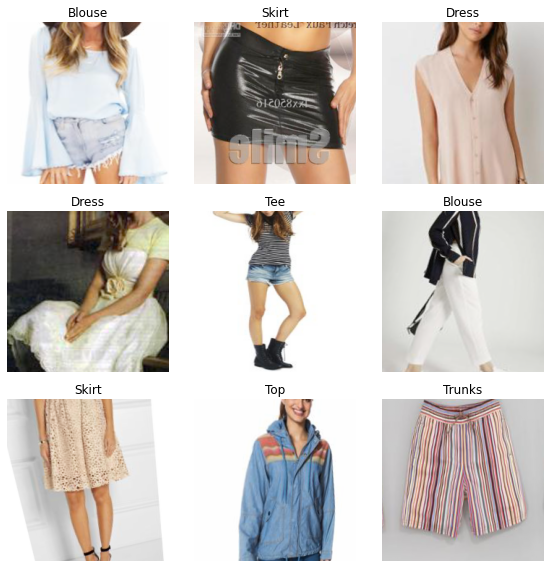

In [13]:
train_image_list = ImageList.from_df(df=data_df, path=root_path, cols='image_path').split_by_idxs(
    (data_df[data_df['dataset_type']=='train'].index),
    (data_df[data_df['dataset_type']=='val'].index)).label_from_df(cols='category')
test_image_list = ImageList.from_df(df=data_df[data_df['dataset_type'] == 'test'], path=root_path, cols='image_path')

data = train_image_list.transform(get_transforms(), size=224).databunch(bs=128).normalize(imagenet_stats)
data.add_test(test_image_list)
data.show_batch(rows=3, figsize=(8,8))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03
Min loss divided by 10: 1.45E-02


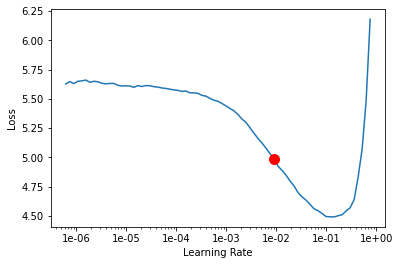

In [14]:
## Conduct ResNet 50 

# see models available: https://docs.fast.ai/vision.models.html
# many options for Resnet, the numbers are the number of layers. 
# More layers are generally more accurate but take longer to train: resnet18, resnet34, resnet50, resnet101, resnet152
# get top 1 and top 5 accuracy
def train_model(data, pretrained_model, model_metrics):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner.lr_find()
    learner.recorder.plot(suggestion=True)
    return learner

pretrained_model = models.resnet18 # simple model that can be trained on free tier
# pretrained_model = models.resnet50 # need pro tier, model I used

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner = train_model(data, pretrained_model, model_metrics)

In [15]:
learner.fit_one_cycle(2, max_lr=1e-02)

## Evaluate Model 

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(30, largest=False, figsize=(15,11), heatmap_thresh=5)

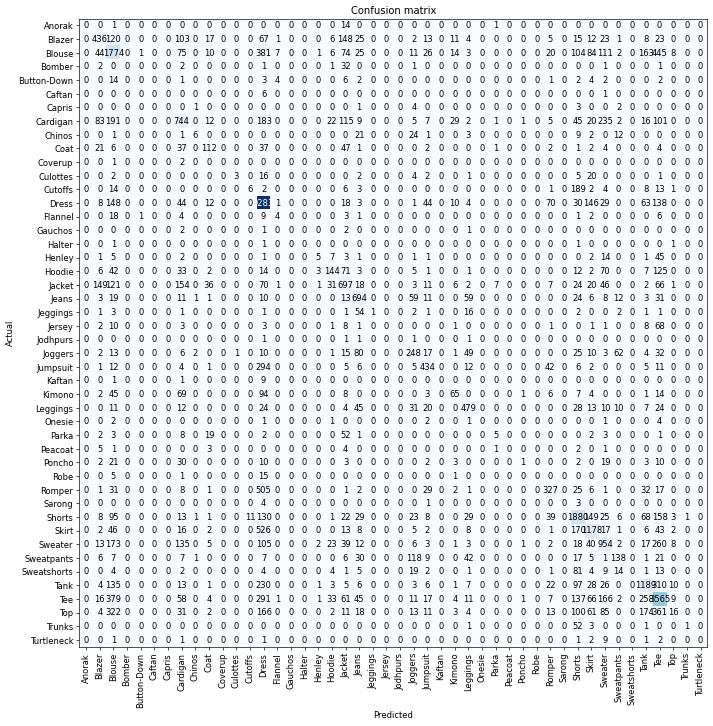

In [17]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Save Model 

In [21]:
# saving the model (temporary, will lose model once environment resets)
learner.save('resnet-fashion')

# saving the model (permanent), need to enter authorization code
drive.mount('/content/gdrive')
learner.save('/content/gdrive/My Drive/resnet18-fashion')
learner.save('/content/gdrive/My Drive/resnet50-fashion')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Use Fastai hooks to retrieve image embeddings

In [22]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [23]:
# load the trained model
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
# if gdrive not mounted:
drive.mount('/content/gdrive') 

# pretrained_model = models.resnet18 # simple model that can be trained on free tier
# model_path = "/content/gdrive/My Drive/resnet18-fashion"

pretrained_model = models.resnet50 # need pro tier
model_path = "/content/gdrive/My Drive/resnet50-fashion"

learner = load_learner(data, pretrained_model, model_metrics, model_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


RuntimeError: ignored

In [24]:
# takes time to populate the embeddings for each image
# Get 2nd last layer of the model that stores the embedding for the image representations
# the last linear layer is the output layer.
saved_features = SaveFeatures(learner.model.module[1][4])
_= learner.get_preds(data.train_ds)
_= learner.get_preds(DatasetType.Valid)

In [25]:
# prepare the data for generating recommendations (exlcude test data)
# get the embeddings from trained model
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_ouput = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
data_df_ouput['embeddings'] = np.array(saved_features.features).tolist()
data_df_ouput

img_path  ...                                         embeddings
0       ./img/Sheer_Pleated-Front_Blouse/img_00000001.jpg  ...  [-22.929767608642578, -19.396574020385742, -2....
1       ./img/Sheer_Pleated-Front_Blouse/img_00000002.jpg  ...  [-43.73393630981445, -36.92156982421875, -28.3...
2       ./img/Sheer_Pleated-Front_Blouse/img_00000004.jpg  ...  [-22.17572593688965, -20.971214294433594, -17....
3       ./img/Sheer_Pleated-Front_Blouse/img_00000008.jpg  ...  [-26.5583553314209, -29.633237838745117, -32.1...
4       ./img/Sheer_Pleated-Front_Blouse/img_00000009.jpg  ...  [-6.623233795166016, -18.075294494628906, -20....
...                                                   ...  ...                                                ...
249217  ./img/Paisley_Print_Babydoll_Dress/img_0000003...  ...  [53.1875114440918, -22.537607192993164, -6.420...
249218  ./img/Paisley_Print_Babydoll_Dress/img_0000004...  ...  [11.850184440612793, -36.0747184753418, -29.87...
249219  ./img/Paisley_Print_Babydoll_Dress/img_0000004...  ...  [40.360538482666016, -4.108407974243164, -7.51...
249220  ./img/Paisley_Print_Babydoll_Dress/img_0000004...  ...  [49.72603225708008, -22.477550506591797, 24.75...
249221  ./img/Paisley_Print_Babydoll_Dress/img_0000005...  ...  [21.60509490966797, -27.63714599609375, -11.55...

[249222 rows x 4 columns]

## Use Approximate Nearest Neighbors to obtain most similar images

In [26]:
# Using Spotify's Annoy
def get_similar_images_annoy(annoy_tree, img_index, number_of_items=12):
    start = time.time()
    img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
    # +1 since we drop first image
    similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return img_id, img_label, data_df_ouput.iloc[similar_img_ids[1:]] 


# for images similar to centroid 
def get_similar_images_annoy_centroid(annoy_tree, vector_value, number_of_items=12):
    start = time.time()
    # dontt need +1 since we not dropping first
    similar_img_ids = annoy_tree.get_nns_by_vector(vector_value, number_of_items)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # dont ignore first item since we using psudeo vector object
    return data_df_ouput.iloc[similar_img_ids] 


def show_similar_images(similar_images_df, fig_size=[10,10], hide_labels=True):
    if hide_labels:
        category_list = []
        for i in range(len(similar_images_df)):
            # replace category with blank so it wont show in display
            category_list.append(CategoryList(similar_images_df['label_id'].values*0,
                                              [''] * len(similar_images_df)).get(i))
    else:
        category_list = [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learner.data.show_xys([open_image(img_id) for img_id in similar_images_df['img_path']],
                                category_list, figsize=fig_size)

In [27]:
ntree = 100
#"angular", "euclidean", "manhattan", "hamming", or "dot"
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(data_df_ouput['embeddings'][0]), metric=metric_choice)

# # takes a while to build the tree
for i, vector in enumerate(data_df_ouput['embeddings']):
    annoy_tree.add_item(i, vector)
_  = annoy_tree.build(ntree)

## Embeddings Centroid Detection

In [28]:
def centroid_embedding(outfit_embedding_list):
    number_of_outfits = outfit_embedding_list.shape[0]
    length_of_embedding = outfit_embedding_list.shape[1]
    centroid = []
    for i in range(length_of_embedding):
        centroid.append(np.sum(outfit_embedding_list[:, i])/number_of_outfits)
    return centroid


In [29]:
def generate_image_mix(list_1, list_2, number_of_items=12, ratio=0.5):
    list_1_num_items = int(number_of_items * ratio)
    list_2_num_items = number_of_items - list_1_num_items
    list_1_temp = np.random.choice(list_1, list_1_num_items, replace=False)
    list_2_temp = np.random.choice(list_2, list_2_num_items, replace=False)
    return np.append(list_1_temp,list_2_temp)

def get_similar_image(outfit_img_ids):
    outfit_embedding_list = []
    for img_index in outfit_img_ids:
        outfit_embedding_list.append(data_df_ouput.iloc[img_index, 3])

    outfit_embedding_list = np.array(outfit_embedding_list)
    outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
    outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

    similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)
    show_similar_images(similar_images_df, fig_size=[15,15])

235234


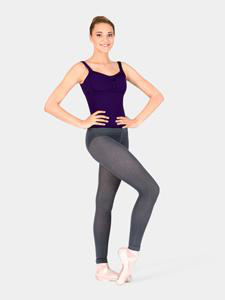

In [30]:

img_index = np.random.randint(len(data_df_ouput),size=1)[0]

print(img_index)
open_image(data_df_ouput.iloc[img_index, 0])

In [31]:
# Selected Seasons Outfit - Spring, Summer, Autumn, Winter
spring_ids = [60676, 70282, 104154, 235539, 30541, 242857, 73647, 109420, 180461, 169567, 22788, 17442, 166013,
              244809, 13771, 174666, 210204, 246338, 243975, 56543,217299, 84747,164253, 194166]
summer_ids = [237651, 102444, 105986, 23610, 3307, 85789, 50391, 27079, 50438, 183651, 217142,230579,
              118421, 28488, 100845, 211697, 133667, 37422, 195827, 79475, 39237, 192176, 248130, 232170]
autumn_ids = [125328, 28806, 81763, 224471, 66524, 239079, 30221, 114039, 51277, 55470, 221654, 226016, 
              4627, 60861, 175997, 60040, 19313, 99686, 37807, 200329, 82795, 75392, 26517, 60452,
              49650, 120012, 60198, 84413, 34788]
winter_ids = [64161, 227306,165196, 240640, 165222, 240343, 206881, 147516, 248762, 165234,
              206341, 248774, 64297, 148709, 165253, 164704, 223365, 206586, 45383, 219502, 217111, 45191,
              84280, 80393, 85121]

In [32]:
print(len(spring_ids),len(summer_ids),len(autumn_ids),len(winter_ids))

24 24 29 25


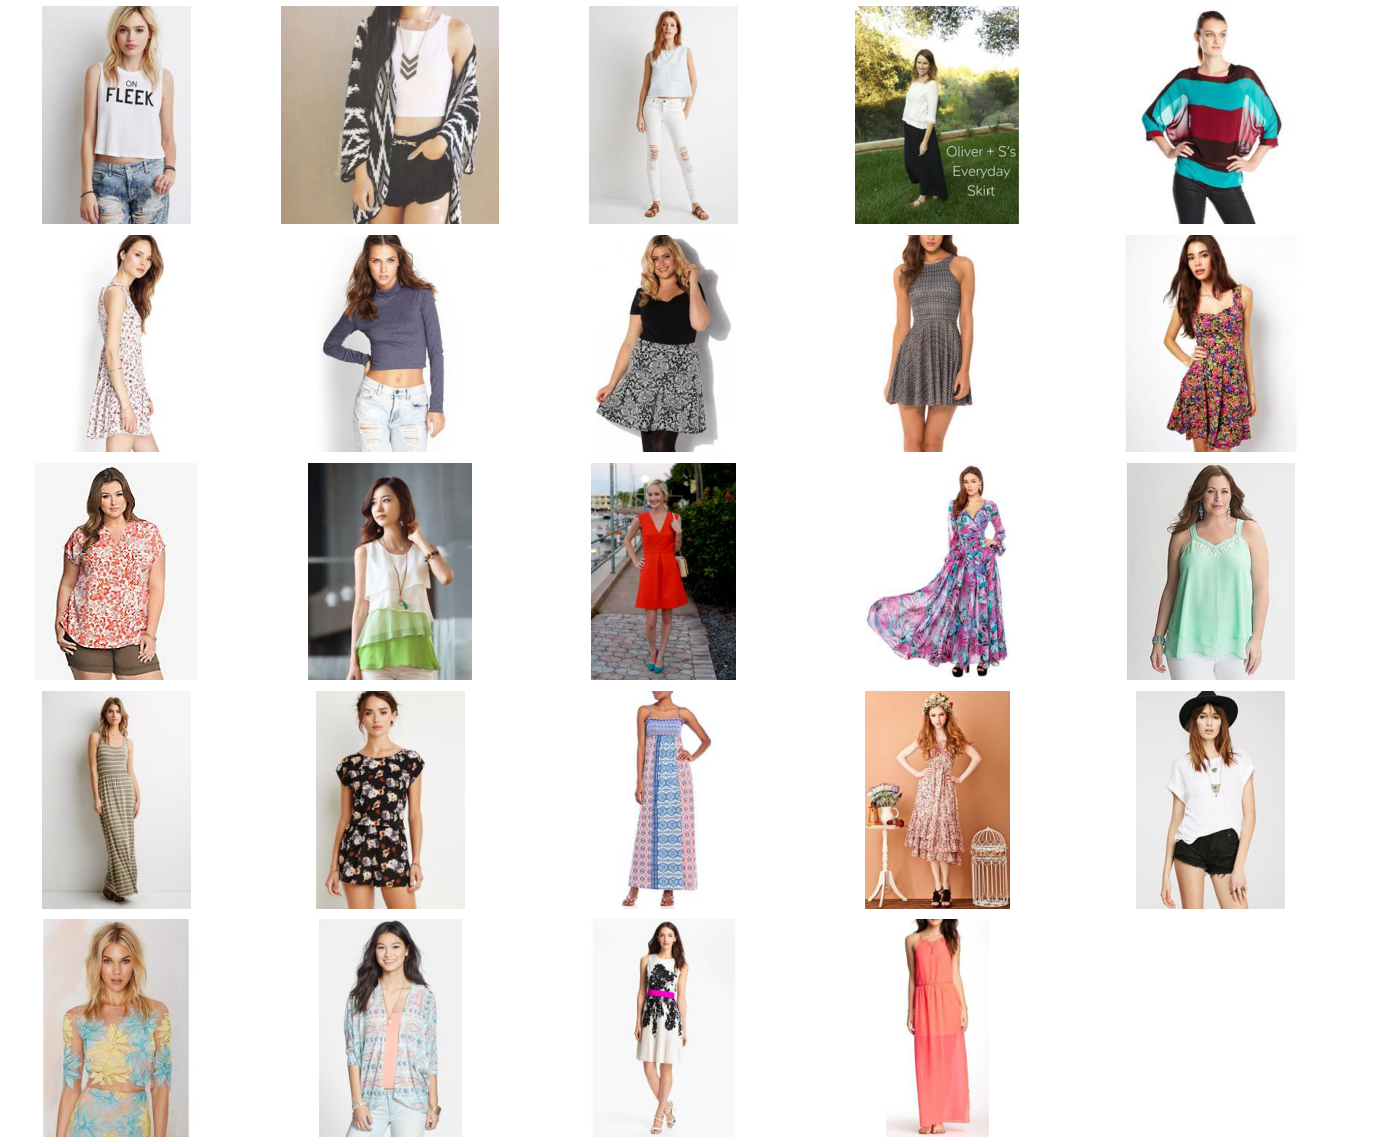

In [33]:
outfits_selected = data_df_ouput.iloc[spring_ids][0:24] 
show_similar_images(outfits_selected, fig_size=[20,16])

## Weather Data 

In [34]:
url = 'https://drive.google.com/uc?id=12IseVEDhsw8Smm7BE3sOzCk1QPF9oQ7g'
output = 'weather_major_cities.csv'
gdown.download(url, output, quiet=False)
weather = pd.read_csv('weather_major_cities.csv')

Downloading...
From: https://drive.google.com/uc?id=12IseVEDhsw8Smm7BE3sOzCk1QPF9oQ7g
To: /content/weather_major_cities.csv
100%|██████████| 14.1M/14.1M [00:00<00:00, 179MB/s]


In [35]:
weather.head()

dt  AverageTemperature  ...  Latitude Longitude
0  1849-01-01              26.704  ...     5.63N     3.23W
1  1849-02-01              27.434  ...     5.63N     3.23W
2  1849-03-01              28.101  ...     5.63N     3.23W
3  1849-04-01              26.140  ...     5.63N     3.23W
4  1849-05-01              25.427  ...     5.63N     3.23W

[5 rows x 7 columns]

In [36]:
weather.City.value_counts()

New York      3239
Toronto       3239
Paris         3239
Istanbul      3239
Chicago       3239
              ... 
Ibadan        1893
Durban        1881
Cape Town     1881
Umm Durman    1857
Lima          1591
Name: City, Length: 100, dtype: int64

## Capetown 

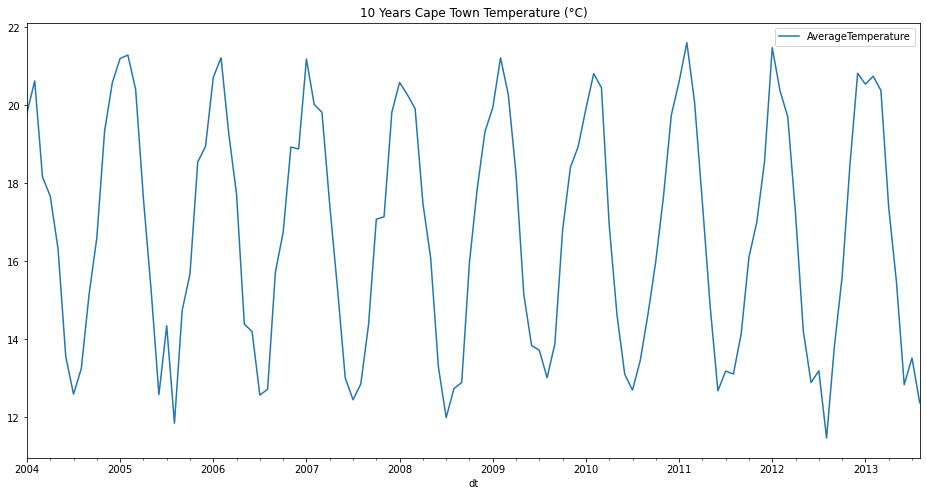

In [37]:
weather_cape = weather.loc[(weather.City=='Cape Town') & (weather.dt>='2004-01-01'),['dt','AverageTemperature']].dropna()
weather_cape['dt'] = pd.to_datetime(weather_cape['dt'], format="%Y-%m-%d")
weather_cape.set_index('dt', inplace=True)
weather_cape.plot(figsize=(16,8), title='10 Years Cape Town Temperature (°C)')
# weather_cape

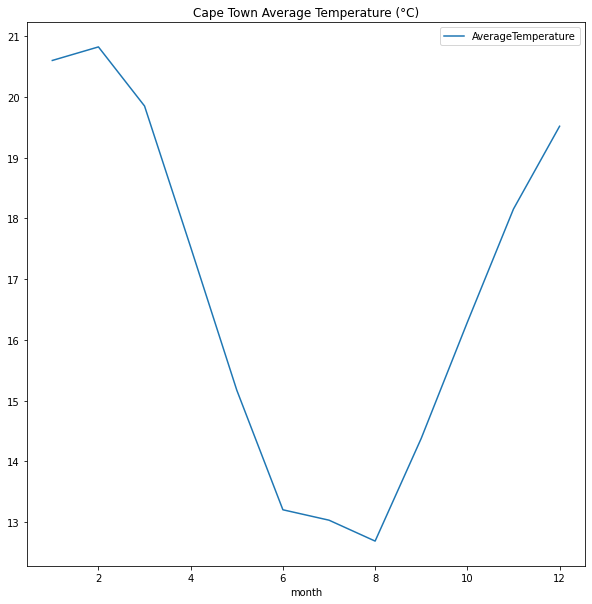

In [38]:
weather_cape['month'] = weather_cape.index.month
weather_cape.groupby('month').mean().plot(figsize=(10,10), title='Cape Town Average Temperature (°C)')

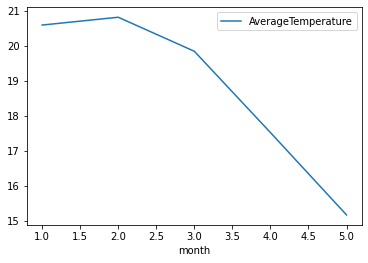

In [39]:
# get temperature from jan to may, seems to increase linearly
weather_cape[(weather_cape.month<=5)].groupby('month').mean().plot()

## New York 

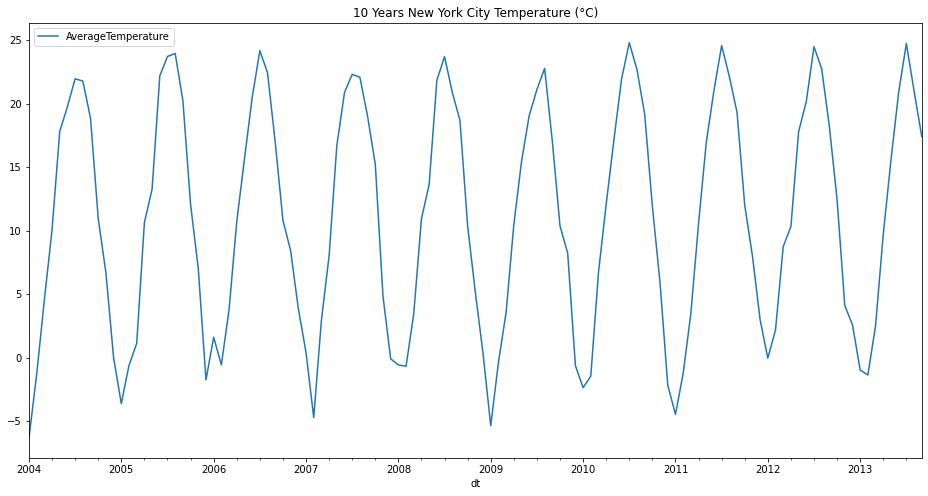

In [40]:
weather_nyc = weather.loc[(weather.City=='New York') & (weather.dt>='2004-01-01'),['dt','AverageTemperature']].dropna()
weather_nyc['dt'] = pd.to_datetime(weather_nyc['dt'], format="%Y-%m-%d")
weather_nyc.set_index('dt', inplace=True)
weather_nyc.plot(figsize=(16,8), title='10 Years New York City Temperature (°C)')
# weather_cape

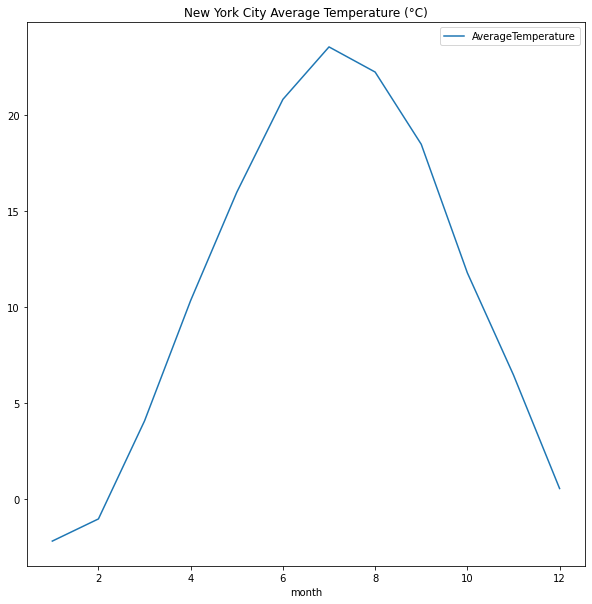

In [41]:
weather_nyc['month'] = weather_nyc.index.month
weather_nyc.groupby('month').mean().plot(figsize=(10,10), title='New York City Average Temperature (°C)')

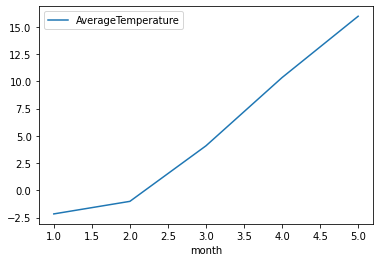

In [42]:
# get temperature from jan to may, seems to decrease linearly from Feb

weather_nyc[(weather_nyc.month<=5)].groupby('month').mean().plot()


## Generate Collections Based on Seasonality (weather and city)

### New York 

2.277851104736328 ms


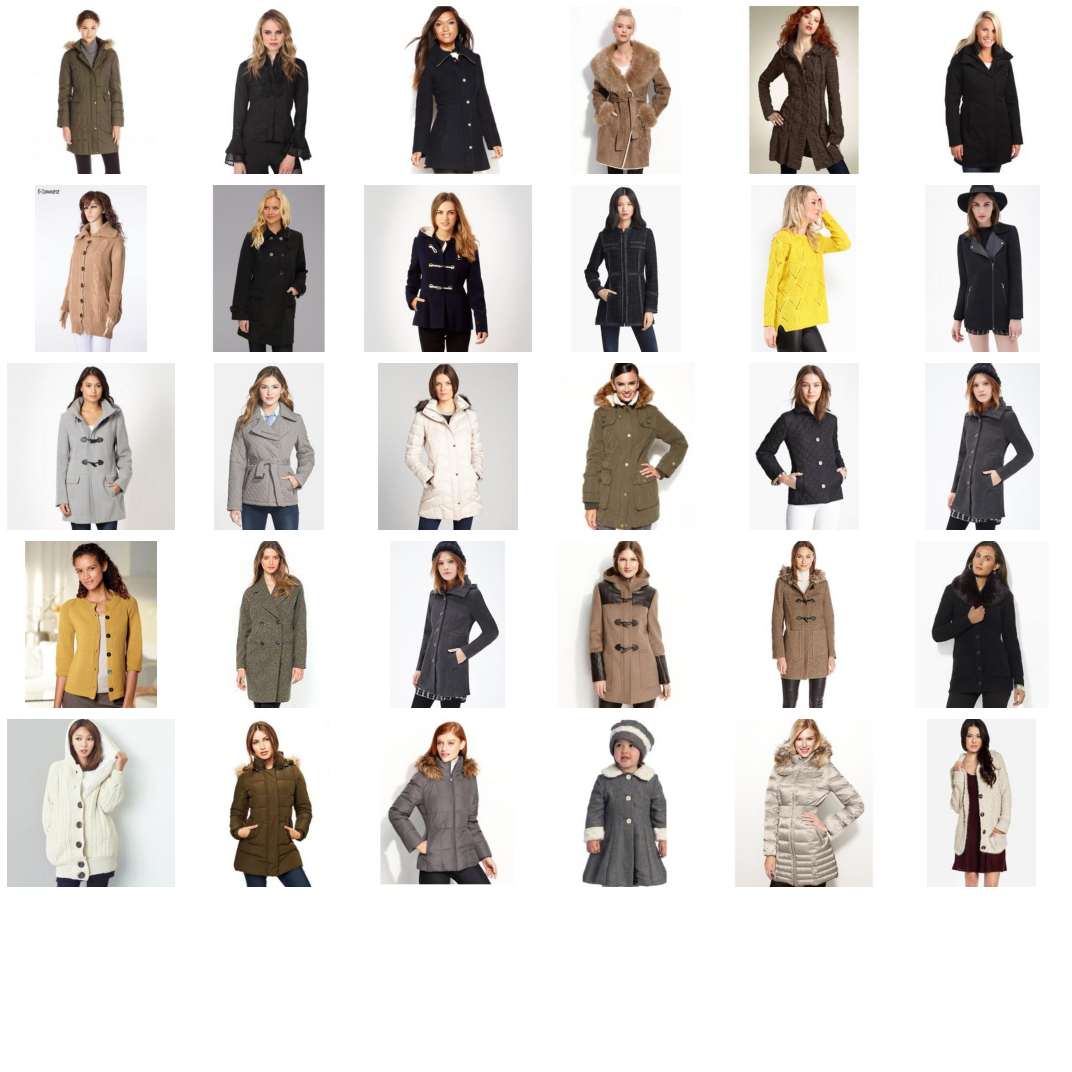

In [43]:
get_similar_image(generate_image_mix(winter_ids, spring_ids, number_of_items=24, ratio=1.0))

## Capetown 

3.128528594970703 ms


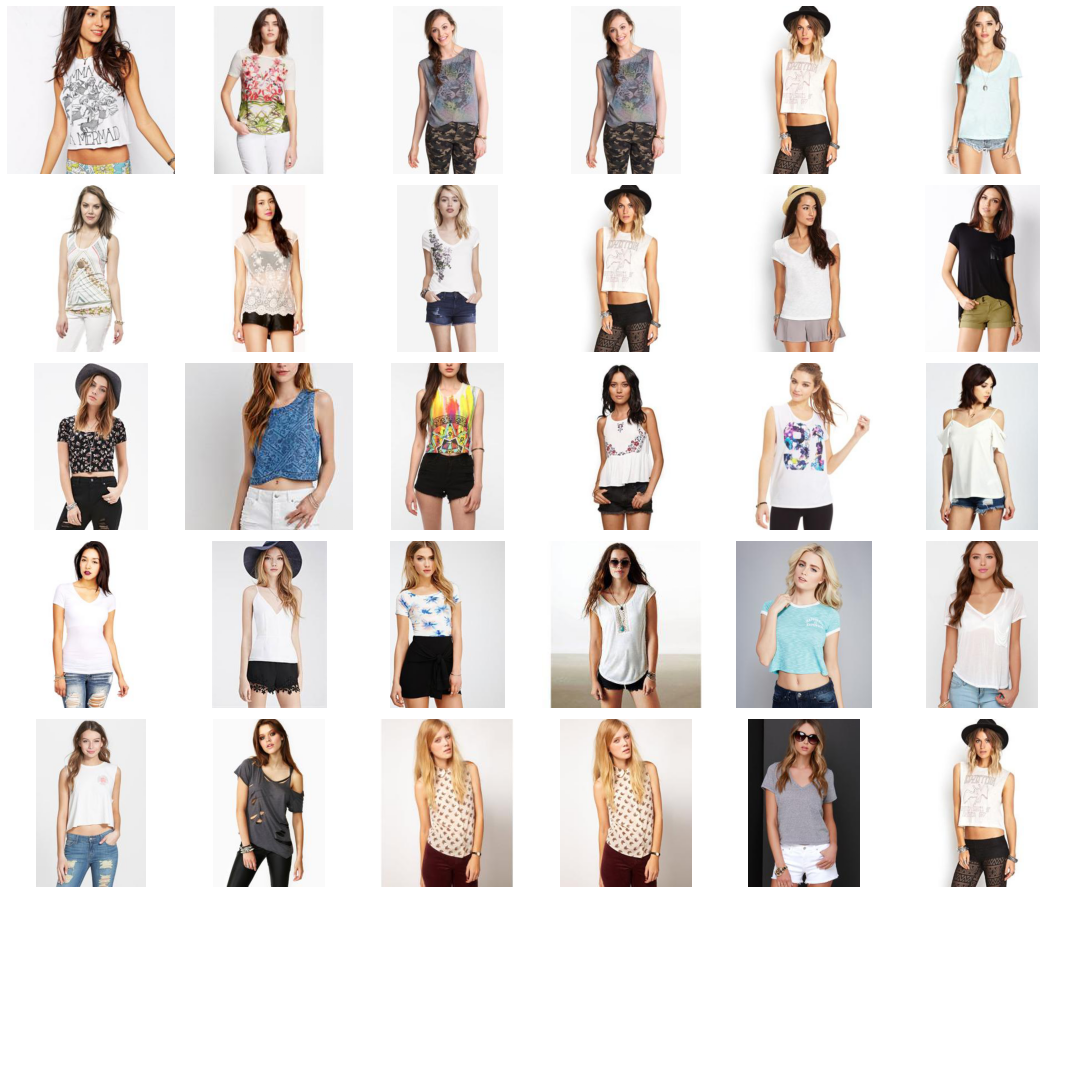

In [44]:
get_similar_image(generate_image_mix(summer_ids, autumn_ids, number_of_items=24, ratio=1.0))

## Reflections 


Try to generate new collections based on different ratios.


Potential Questions I can Answer:  
Are the results "good"? How can the recommendations be improved?
What other kinds of time-series data will you include in the model? How will it change the result?

##  